In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from google.colab import drive
# drive.mount('/content/drive')
INPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/free-spoken-digit-dataset-master/recordings'
OUTPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project'


# list all the files and directories within a specified directory
parent_list = os.listdir(INPUT_DIR)
print(len(parent_list)) # 6 speakers, 10 digits, 50 recordings for each digit
for i in range(10):
    print(parent_list[i])

3000
5_nicolas_9.wav
3_yweweler_14.wav
1_lucas_5.wav
2_george_44.wav
4_yweweler_38.wav
3_yweweler_28.wav
4_yweweler_10.wav
3_george_1.wav
1_nicolas_15.wav
1_jackson_42.wav


In [2]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory = os.path.join(OUTPUT_DIR, 'audio-images'),
    shuffle = True,
    color_mode = 'rgb',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "training",
    seed = 0
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory = os.path.join(OUTPUT_DIR, 'audio-images'),
    shuffle = True,
    color_mode = 'rgb',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "validation",
    seed = 0
)

def split_dataset(dataset, split_fraction=0.5):
  dataset_size = len(dataset)
  split_size = int(dataset_size * split_fraction)
  dataset = dataset.shuffle(buffer_size=dataset_size)
  return dataset.take(split_size), dataset.skip(split_size)

test_dataset, valid_dataset = split_dataset(valid_dataset, split_fraction=0.5)
print('validation dataset is further split into 50/50 test/valid dataset', '\n')
print('batch size:', BATCH_SIZE)
print('train_dataset batch numbers:', len(train_dataset))
print('valid_dataset batch numbers:', len(valid_dataset))
print('test_dataset batch numbers:', len(test_dataset))

Found 3000 files belonging to 10 classes.
Using 2100 files for training.
Found 3000 files belonging to 10 classes.
Using 900 files for validation.
validation dataset is further split into 50/50 test/valid dataset 

batch size: 32
train_dataset batch numbers: 66
valid_dataset batch numbers: 15
test_dataset batch numbers: 14


In [3]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [4]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
66/66 [==============================] - 14s 199ms/step - loss: 0.7112 - accuracy: 0.7890 - val_loss: 3.2406 - val_accuracy: 0.0841
Epoch 2/10
66/66 [==============================] - 14s 200ms/step - loss: 0.2214 - accuracy: 0.9438 - val_loss: 2.7822 - val_accuracy: 0.2876
Epoch 3/10
66/66 [==============================] - 13s 198ms/step - loss: 0.1335 - accuracy: 0.9681 - val_loss: 2.5734 - val_accuracy: 0.2562
Epoch 4/10
66/66 [==============================] - 14s 199ms/step - loss: 0.0922 - accuracy: 0.9776 - val_loss: 2.4244 - val_accuracy: 0.2937
Epoch 5/10
66/66 [==============================] - 13s 199ms/step - loss: 0.0706 - accuracy: 0.9852 - val_loss: 2.0925 - val_accuracy: 0.2979
Epoch 6/10
66/66 [==============================] - 13s 199ms/step - loss: 0.0518 - accuracy: 0.9876 - val_loss: 0.6219 - val_accuracy: 0.8075
Epoch 7/10
66/66 [==============================] - 13s 199ms/step - loss: 0.0359 - accuracy: 0.9938 - val_loss: 0.5384 - val_accuracy: 0.8363

In [5]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# # Compile model
# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.RMSprop(),
#     metrics=['accuracy'],
# )

# # Train model for 10 epochs, capture the history

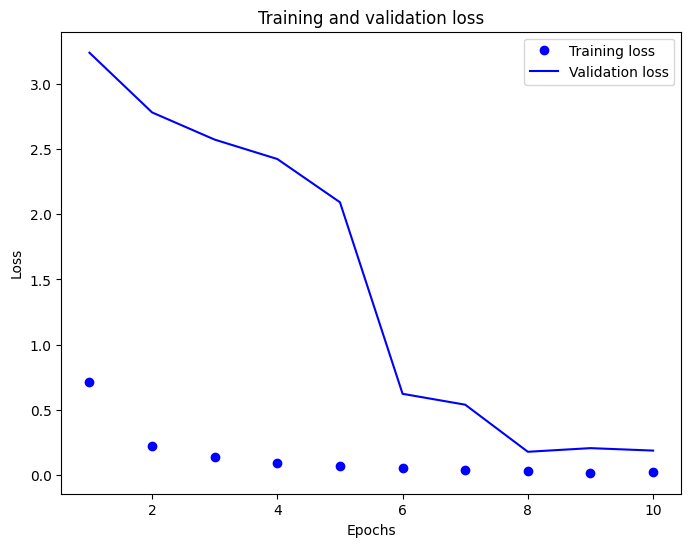

In [6]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

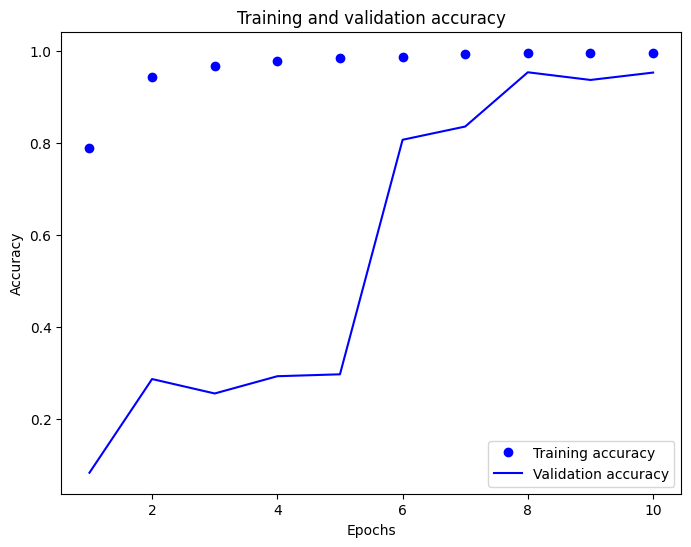

In [7]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.206955, final accuracy: 0.935417


In [9]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

In [10]:
import time

# Start the timer.
t0 = time.process_time()


final_loss, final_acc = model.evaluate(test_dataset, verbose=0)

# Stop the timer.0
t1 = time.process_time()

print((t1-t0), len(valid_dataset), 'batches')
avg_time = (t1 - t0) / len(valid_dataset)
print("Average time per batch: ", avg_time)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

# penalty = ... # whatever, we'll find this out later.
# adjusted_acc = final_acc / (1 + penalty * avg_time)

# print("Time adjusted final accuracy: {1:.6f}".format(adjusted_acc))

9.980984000000035 15 batches
Average time per batch:  0.6653989333333357
Final loss: 290320.281250, final accuracy: 0.118304


9.980984000000035 15 batches
Average time per batch:  0.6653989333333357
Final loss: 290320.281250, final accuracy: 0.118304